In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(directory):
    labels = []
    features = []
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                try:
                    if file.endswith('.wav'):
                        y, sr = librosa.load(file_path, sr=None)
                        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                        mfcc = np.mean(mfcc.T, axis=0)
                        features.append(mfcc)
                        labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(features), labels


In [ ]:


def create_model(input_shape, num_classes):
    model = Sequential([
        LSTM(256, input_shape=(input_shape, 1), return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_test, y_test):

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    return history


In [ ]:
train_directory = '/content/drive/My Drive/yapayzeka/Sound Source 1/'
X_train, train_labels = load_data(train_directory)

test_directory = '/content/drive/My Drive/yapayzeka/test 1/'
X_test, test_labels = load_data(test_directory)

label_dict = {label: i for i, label in enumerate(sorted(set(train_labels + test_labels)))}

y_train = to_categorical([label_dict[label] for label in train_labels])
y_test = to_categorical([label_dict[label] for label in test_labels])

model = create_model(X_train.shape[1], y_train.shape[1])
history = train_model(model, X_train, y_train, X_test, y_test)

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

scores = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', scores[1])
model.save('model.h5')




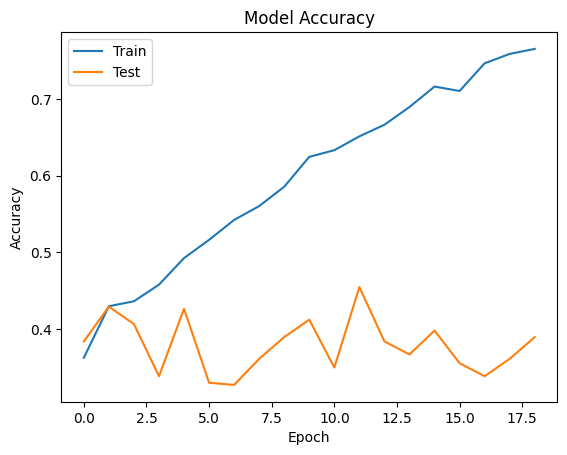

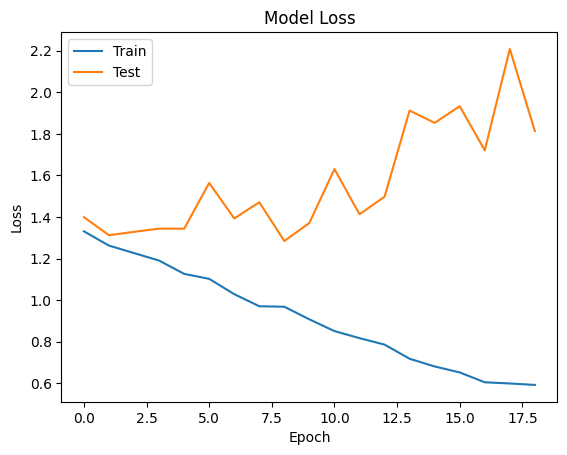

11/11 [==============================] - 1s 23ms/step - loss: 2.8407 - accuracy: 0.4915
Test Loss: 2.84073543548584
Test Accuracy: 0.49147728085517883


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


model = load_model('model.h5')
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")